In [25]:
# Configuration parameters
RESULT_FOLDER = "data/output/full_bias_add_1/"
CLASSES_MODEL_NAME = "S1_bias_add"
ALPHA = 0.05
MANUAL_EXPERIMENT_COUNT = 48000
EXPERIMENT_DURATION_SEC = 3.75

MIN_PRECISION = 0.015
RELATIVE_PRECISION = 1.0
MAX_PRECISION = 0.05

CELLS_GROWTH_FACTOR = 1.1

In [26]:
from scipy.stats import chi2


def calculate_B(r, k):
    # Calculate the upper r times 100-th percentile
    q = 1 - (r / k)

    # Calculate B using the inverse of the cumulative distribution function (ppf)
    B = chi2.ppf(q, df=1)

    return B

In [27]:
import math


def calculate_confint(p, B, N):
    """
    Returns the same intervals as the statsmodel.multinomial_confint function
    """
    b_n = B / N

    delta = (2 * p + b_n) * (2 * p + b_n) - 4 * (1 + b_n) * p * p

    x_1 = (2 * p + b_n - math.sqrt(delta)) / (2 * (1 + b_n))
    x_2 = (2 * p + b_n + math.sqrt(delta)) / (2 * (1 + b_n))

    return [x_1, x_2]

In [28]:
def estimate_sample_size(k, p, d, alpha=0.05):
    B = calculate_B(alpha, k)
    delta_sq = 4 * d * d * (B * B - B * B * d * d) + (
        4 * B * p - 4 * B * p * p - 2 * B * d * d
    ) * (4 * B * p - 4 * B * p * p - 2 * B * d * d)

    return (4 * B * p - 4 * B * p * p - 2 * B * d * d + math.sqrt(delta_sq)) / (
        2 * d * d
    )

In [29]:
def clamp(val, min_v, max_v):
    if val < min_v:
        return min_v
    if val > max_v:
        return max_v
    return val


def precision_function(x):
    return clamp(x * RELATIVE_PRECISION, MIN_PRECISION, MAX_PRECISION)

In [30]:
from statsmodels.stats.proportion import multinomial_proportions_confint
import json
import os

CLASSES_MODEL = os.path.join(
    RESULT_FOLDER, CLASSES_MODEL_NAME, f"{CLASSES_MODEL_NAME}.json"
)

CONFINT_PCT = (1 - ALPHA) * 100

with open(CLASSES_MODEL, "r") as f:
    classes_json = json.load(f)

parameters_cells = []
domain_classes_cells = []
corrupted_count = None
for class_name, class_data in classes_json.items():
    if class_name == "_tensor_count":
        corrupted_count = class_data
        continue
    if class_name.startswith("_"):
        continue
    for cell in class_data["parameters"]:
        parameters_cells.append({"_sp_class": class_name, **cell})
    for cell in class_data["domain_classes"]:
        domain_classes_cells.append({"_sp_class": class_name, **cell})

parameters_cells = sorted(parameters_cells, key=lambda x: x["count"], reverse=True)
domain_classes_cells = sorted(
    domain_classes_cells, key=lambda x: x["count"], reverse=True
)

all_params_counts = [data["count"] for data in parameters_cells]
all_domain_counts = [data["count"] for data in domain_classes_cells]

params_rel_freqs = [data["count"] / corrupted_count for data in parameters_cells]
domain_rel_freqs = [data["count"] / corrupted_count for data in domain_classes_cells]


print(f"Number of corrupted tensors: {corrupted_count}")
print(f"Number of spatial parameters cells: {len(parameters_cells)}")
print(f"Number of domain classes cells: {len(domain_classes_cells)}")

params_confints = multinomial_proportions_confint(
    all_params_counts, alpha=ALPHA, method="goodman"
)
domain_confints = multinomial_proportions_confint(
    all_domain_counts, alpha=ALPHA, method="goodman"
)

print(f"Spatial Paramters:")
print(
    f"Highest estimated frequency: {all_params_counts[0] / corrupted_count:.4f}. Confidence interval at {CONFINT_PCT}%: {params_confints[0]}"
)
print(
    f"Lowest estimated frequency: {all_params_counts[-1] / corrupted_count:.4f}. Confidence interval at {CONFINT_PCT}%: {params_confints[-1]}"
)
print(
    estimate_sample_size(
        len(parameters_cells),
        all_params_counts[0] / corrupted_count,
        params_confints[0][1] - params_confints[0][0],
    )
)

print(f"Domain Classes:")
print(
    f"Highest estimated frequency: {all_domain_counts[0] / corrupted_count:.4f}. Confidence interval at {CONFINT_PCT}%: {domain_confints[0]}"
)
print(
    f"Lowest estimated frequency: {all_domain_counts[-1] / corrupted_count:.4f}. Confidence interval at {CONFINT_PCT}%: {domain_confints[-1]}"
)

Number of corrupted tensors: 3620
Number of spatial parameters cells: 15
Number of domain classes cells: 15
Spatial Paramters:
Highest estimated frequency: 0.7702. Confidence interval at 95.0%: [0.74901366 0.79003493]
Lowest estimated frequency: 0.0025. Confidence interval at 95.0%: [0.00096862 0.00636625]
3619.9999999999773
Domain Classes:
Highest estimated frequency: 0.4616. Confidence interval at 95.0%: [0.4374018  0.48598496]
Lowest estimated frequency: 0.0014. Confidence interval at 95.0%: [0.00040258 0.00472759]


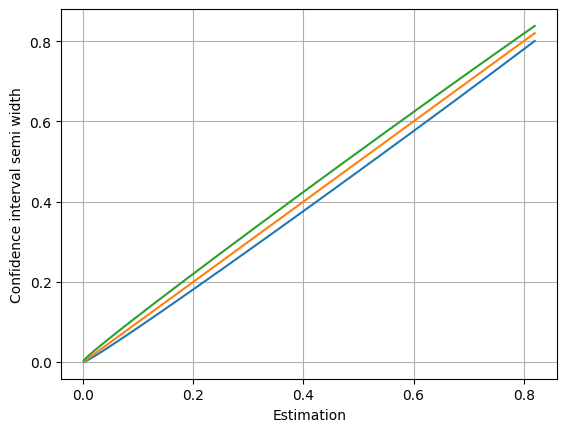

In [31]:
calculate_confint(
    all_params_counts[-1] / corrupted_count,
    calculate_B(ALPHA, len(all_params_counts)),
    corrupted_count,
)


import matplotlib.pyplot as plt
import numpy as np

max_x = all_params_counts[0] / corrupted_count + 0.05

x = np.linspace(0.001, max_x, 1000)

y_center = [x_i for x_i in x]

the_B = calculate_B(ALPHA, len(all_params_counts))
y_interval = [calculate_confint(x_i, the_B, corrupted_count) for x_i in x]

y_small = [y_i[0] for y_i in y_interval]
y_big = [y_i[1] for y_i in y_interval]


plt.plot(x, y_small, label="lower limit")
plt.plot(x, y_center, label="center")
plt.plot(x, y_big, label="higher limit")
plt.xlabel("Estimation")
plt.ylabel("Confidence interval semi width")
plt.title("")
plt.grid(True)
plt.show()

In [32]:
from statsmodels.stats.proportion import proportion_confint

REPORT_FILE = os.path.join(RESULT_FOLDER, "global_report.json")

with open(REPORT_FILE, "r") as f:
    report = json.load(f)

if "total_experiments" in report and report["total_experiments"] is not None:
    experiments = report["total_experiments"]
else:
    experiments = MANUAL_EXPERIMENT_COUNT
    print("No total_experiment field found in report. Using manual one")

print(f"Experiment count: {experiments}")
print(f"Corrupted Tensor count: {corrupted_count}")

successes = report["classified_tensors"]
sdc_estimate = successes / experiments
sdc_confint = proportion_confint(successes, experiments, alpha=ALPHA, method="normal")
sampling_mul_factor = 1 / sdc_estimate
print(
    f"Estimation of SDC probability: {sdc_estimate:.6f}. Confidence interval at {CONFINT_PCT}%: {sdc_confint}"
)
print(
    f"Sampling multiplicative factor: {1/sdc_estimate:.6f}, Confidence interval at {CONFINT_PCT}%: {(1 / sdc_confint[1], 1 / sdc_confint[0])}"
)

Experiment count: 19126
Corrupted Tensor count: 3620
Estimation of SDC probability: 0.189323. Confidence interval at 95.0%: (0.1837712735753649, 0.19487559456224882)
Sampling multiplicative factor: 5.281966, Confidence interval at 95.0%: (5.131478891681183, 5.4415468780538125)


In [33]:
def plot_precision(
    relative_freqs,
    current_N,
    next_Ns=[],
    sdc_proportion=1.0,
    exp_duration=EXPERIMENT_DURATION_SEC,
    alpha=ALPHA,
    n_classes_margin=CELLS_GROWTH_FACTOR,
    point_count=1000,
    xscale="linear",
    title="",
    prec_function=lambda x: x,
    min_x = None,
    max_x = None
):
    x_max = max_x or min(max(relative_freqs) + 0.05, 1.0)
    x_min = min_x or max(min(relative_freqs) / 1.5, 0.0)
    x = np.linspace(x_min, x_max, point_count)
    n_classes = len(relative_freqs)
    current_B = calculate_B(alpha, n_classes)
    future_B = calculate_B(alpha, n_classes * n_classes_margin)

    Ns = [current_N, *next_Ns]
    relative_freqs_clamped = [rf for rf in relative_freqs if x_min <= rf <= x_max]
    for i, n in enumerate(Ns):
        the_B = future_B
        time_needed_days = ((n - current_N) / sdc_proportion) * exp_duration / 86400
        time_string = f"{time_needed_days:.4f} days"
        label = f'N = {n} {" (current)" if i == 0 else time_string}'
        intervals = [calculate_confint(p, the_B, n) for p in x]
        lenghts = [b - a for a, b in intervals]

        point_intervals = [calculate_confint(p, the_B, n) for p in relative_freqs_clamped]
        point_lenghts = [b - a for a, b in point_intervals]
        plt.plot(x, lenghts, label=label)
        plt.scatter(relative_freqs_clamped, point_lenghts)

    target_value = [prec_function(x_i) for x_i in x]

    plt.plot(x, target_value, "--", label="Precision function")

    plt.xscale(xscale)
    plt.xlabel("Point wise Estimation")
    plt.ylabel("Confidence interval full width")
    plt.title("")
    plt.legend()
    plt.grid(True)
    plt.show()

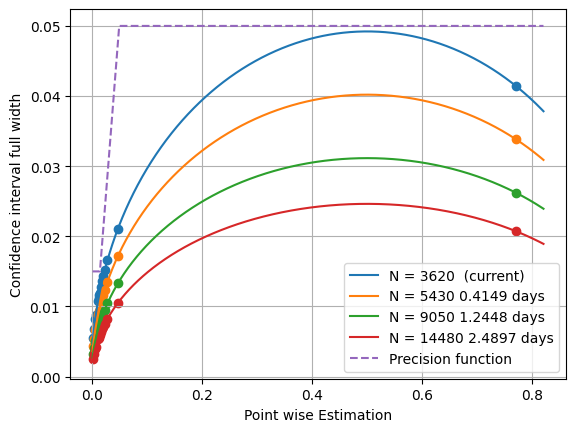

In [34]:
plot_precision(
    params_rel_freqs,
    corrupted_count,
    [int(corrupted_count * 1.5), int(corrupted_count * 2.5), int(corrupted_count * 4)],
    sdc_proportion=sdc_estimate,
    xscale="linear",
    prec_function=precision_function,
)

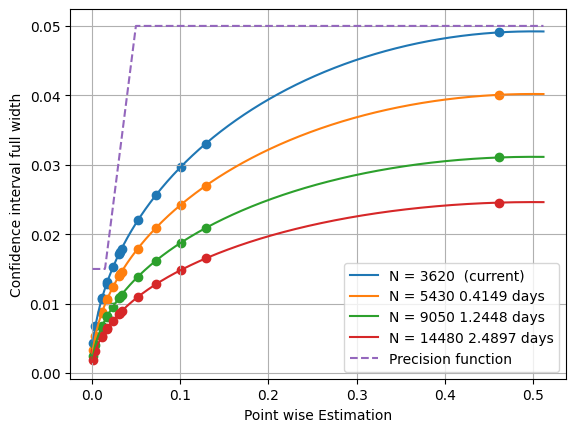

In [35]:
plot_precision(
    domain_rel_freqs,
    corrupted_count,
    [int(corrupted_count * 1.5), int(corrupted_count * 2.5), int(corrupted_count * 4)],
    sdc_proportion=sdc_estimate,
    xscale="linear",
    prec_function=precision_function,
)

In [36]:
def calculate_sample_size(frequencies, conf_intervals, precision_f):
    max_sample_size = 0
    max_sample_size_idx = None
    max_sample_size_precision = None

    n_samples = sum(frequencies)
    n_cells = len(frequencies)
    estimate_cells = int(math.ceil(n_cells * CELLS_GROWTH_FACTOR))

    for i, confint in enumerate(conf_intervals):
        if frequencies[i] < 5:
            continue
        estimate_p = frequencies[i] / n_samples
        # desired_precision = max(MIN_PRECISION, min(estimate_p / 4, MAX_PRECISION))
        desired_precision = precision_f(estimate_p)
        est_sample_size = estimate_sample_size(
            alpha=ALPHA, k=estimate_cells, p=estimate_p, d=desired_precision
        )
        if est_sample_size > max_sample_size:
            max_sample_size = est_sample_size
            max_sample_size_idx = i
            max_sample_size_precision = desired_precision

    return max_sample_size, max_sample_size_idx, max_sample_size_precision


print(f"Spatial Classes Parameters")
params_sample_size, params_max_idx, params_precision = calculate_sample_size(
    all_params_counts, params_confints, precision_function
)


print(f"Cell that requires the highest sample size: {parameters_cells[params_max_idx]}")
print(
    f"Current frequency for that cell {all_params_counts[params_max_idx] / corrupted_count:.6f} {params_confints[params_max_idx]}"
)
print(f"Estimated precision for that cell: {params_precision}")
print(f"Number of corrupted tensors required: {params_sample_size}")

print(f"Domain classes")
domain_sample_size, domain_max_idx, domain_precision = calculate_sample_size(
    all_domain_counts, domain_confints, precision_function
)
print(
    f"Cell that requires the highest sample size: {domain_classes_cells[domain_max_idx]}"
)
print(
    f"Current frequency for that cell {all_domain_counts[domain_max_idx] / corrupted_count:.6f} {domain_confints[domain_max_idx]}"
)
print(f"Estimated precision for that cell: {domain_precision}")
print(f"Number of corrupted tensors required: {domain_sample_size}")


max_sample_size = max(domain_sample_size, params_sample_size)
remaining_corr_tensors = int(math.ceil(max_sample_size - corrupted_count))

print(
    f"Estimated Total of corrupted tensors required: {int(math.ceil(max_sample_size))}"
)


if remaining_corr_tensors > 0:
    print(f"Estimated number of corrupted tensors remaining: {remaining_corr_tensors}")

    remaining_injections = int(math.ceil(remaining_corr_tensors / sdc_estimate))

    print(f"Estimated number of injections remaining: {remaining_injections}")
    print(
        f"Estimated duration of the next campaign: {remaining_injections * EXPERIMENT_DURATION_SEC / 60 / 60 / 24:.5f} days"
    )
else:
    print(f"No corrupted tensors left to obtain")

Spatial Classes Parameters
Cell that requires the highest sample size: {'_sp_class': 'single_block', 'keys': {'block_size': 32, 'block_corruption_pct': [90.0, 100.0]}, 'stats': {}, 'conditional_frequency': 0.9653739612188366, 'overall_frequency': 0.7701657458563536, 'count': 2788}
Current frequency for that cell 0.770166 [0.74901366 0.79003493]
Estimated precision for that cell: 0.05
Number of corrupted tensors required: 2499.454750465889
Domain classes
Cell that requires the highest sample size: {'_sp_class': 'single_block', 'in_range': [100.0, 100.0], 'count': 1671, 'frequency': 0.578601108033241}
Current frequency for that cell 0.461602 [0.4374018  0.48598496]
Estimated precision for that cell: 0.05
Number of corrupted tensors required: 3507.788501526966
Estimated Total of corrupted tensors required: 3508
No corrupted tensors left to obtain
